# Is Passion the Only Factor That Influences Job Satisfaction for Developers?

This notebook has the exploratory analysis code used for the analysis based on publicly available data for Stack Overflow Developers survey 2020. The article based on this is published on medium.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_colwidth = 100

# Load data

In [3]:
strack_raw = pd.read_csv('/Users/dinushadissanayake/Documents/Scripting/udacity/stackoverflow/developer_survey_2020/survey_results_public.csv')
schema=pd.read_csv('/Users/dinushadissanayake/Documents/Scripting/udacity/stackoverflow/developer_survey_2020/survey_results_schema.csv')

In [62]:
strack_raw.shape

(64461, 61)

# Functions

In [4]:
def get_plot_counts(df, col_name):
    """
    get row counts in a pandas dataframe and a fraction (row counts of relevant/tot row count) in a plot of the column specified
    input:
    df - the pandas dataframe
    col_name - the column name
    output:
    new_df - a dataframe of each look_for with the count of how often it shows up
    plt_val - bar chart for each value in x axis and y axis value/total
    """
    val_count = df[col_name].value_counts()
    new_df = (val_count
                    .reset_index()
                    .sort_values(by=[col_name],
                                 ascending=False)
                   )
    plt_val = (val_count/df.shape[0]).plot(kind='bar')
    plt.title(col_name)
    return new_df, plt_val
    

In [5]:
def clean_series_in_columns(df,col_name, split_delimiter = ';'):
    """
    inputs: 
    df: pandas dataframe
    col_name: name of the column with values to be cleaned
    
    outputs:
    df_cleaned: Panda's dataframe without nulls in the col_name with the unique element seperated and respective counts
    bar plot df_cleaned figures as fractions
    """
    df_sel = df[col_name]
    df_sel = df_sel.dropna().reset_index()
    df_sel = df_sel[col_name].str.split(split_delimiter)
    str_list=[]
    
    for i in range(len(df_sel)):
        str_list += df_sel[i]
        
    for i in range(len(str_list)):
        str_list[i] = str_list[i].strip()
    
    str_set = list(set(str_list))
    str_set
    
    c = Counter(str_list)
    print(c.items())
    
    df_cleaned = pd.DataFrame({'str_seleted':list(c.keys()),'counts':list(c.values())})
    df_cleaned['frac'] = df_cleaned['counts']/df_cleaned.sum()['counts']
    cleaned_fac = df_cleaned.set_index('str_seleted').sort_values(by =['frac'], ascending=False )
    cleaned_fac['frac'].plot(kind='bar')
    return df_cleaned

    

# Filter the data in scope

Scope of the analysis is full time employed, developers who are aged between 15 to 60

In [6]:
# filter developers who work full time
developers = strack_raw[strack_raw['MainBranch']=='I am a developer by profession']
developers = developers[developers['Employment']=='Employed full-time']

# filter the developers with the target variable job satisfaction not null
developers = developers[developers['JobSat'].notna()]

# Check age outliers
data = developers
print("Highest allowed",data['Age'].mean() + 3*data['Age'].std())
print("Lowest allowed",data['Age'].mean() - 3*data['Age'].std())

# outlier count 

df = data[(data["Age"]>60) | (data["Age"]<15)]
data.shape, data.isna().sum()['Age'],df.shape

# remove outliers
developers_adj = developers[(developers["Age"]<=60)]
developers_adj = developers_adj[developers_adj["Age"]>=15]
developers_adj.shape

Highest allowed 56.13748043774604
Lowest allowed 7.053106645718415


(28428, 61)

# New columns with bucketize data

In [7]:
# add a new column by grouping columns to get satisfied, dissatisfied and no difference
data = developers_adj
colname = 'JobSat'
new_col_name = 'JobSat_new'
conditions = [
    (data[colname] == 'Very satisfied') | (data[colname] == 'Slightly satisfied'),
    (data[colname] == 'Very dissatisfied') | (data[colname] == 'Slightly dissatisfied')]
choices = ['Satisfied', 'Dissatisfied']
data[new_col_name] = np.select(conditions, choices, default='No difference')
developers_adj = data

In [8]:
# add age bucket
developers_adj['quantile_age'] = pd.qcut(developers_adj['Age'], q=4)

# Overall satisfaction Rates

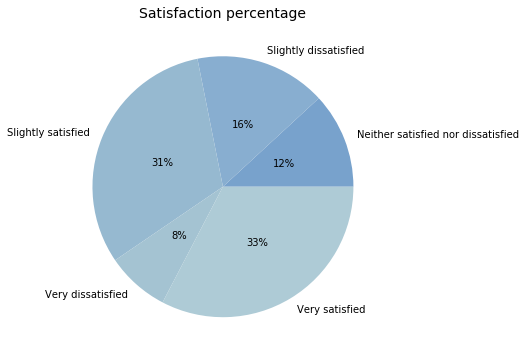

In [9]:
# Satisfaction perfcentages

data=developers_adj[["JobSat", "Respondent"]]
data = data.groupby("JobSat")['Respondent'].count()
colors = ['#78A2CC','#88AED0','#96B9D0', '#A4C3D2' , '#AECBD6']
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  labels=labels, pctdistance=0.5, colors = colors)
plt.title("Satisfaction percentage", fontsize=14);

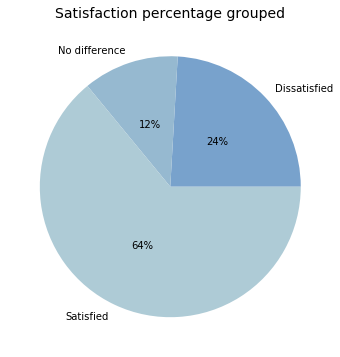

In [10]:
data=developers_adj[["JobSat_new", "Respondent"]]
data = data.groupby("JobSat_new")['Respondent'].count()
colors = ['#78A2CC','#96B9D0' , '#AECBD6']
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  labels=labels, pctdistance=0.5, colors = colors)
plt.title("Satisfaction percentage grouped", fontsize=14);

# Country wise analysis

In [11]:
# unique country counts
developers_adj.Country.drop_duplicates().shape

(150,)

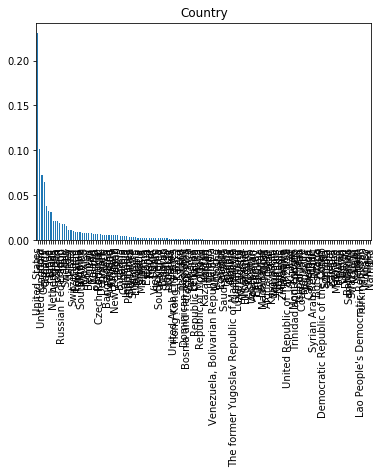

In [12]:
# get counts for each country
new_df, plt_val = get_plot_counts(developers_adj, 'Country')
more30count_ls = new_df[new_df['Country']>=30]['index'].values.tolist()

,Country,count_respondents_country
0,United States,6549
1,India,2893
2,United Kingdom,2059
3,Germany,1845
4,Canada,1077
...,...,...
65,Thailand,41
66,Dominican Republic,38
67,Bosnia and Herzegovina,37
68,Costa Rica,33


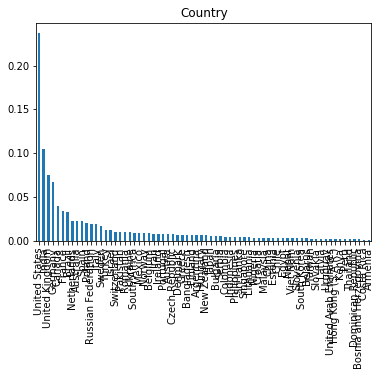

In [13]:
# countries with more than 30 respondents
new_df_count, plt_val = get_plot_counts(developers_adj[developers_adj['Country'].isin(more30count_ls)], 'Country')
pd.set_option('display.max_rows', 10)
new_df_count.columns = ['Country', 'count_respondents_country']
new_df_count

,index,JobSat_new
0,Satisfied,17771
1,Dissatisfied,6625
2,No difference,3270


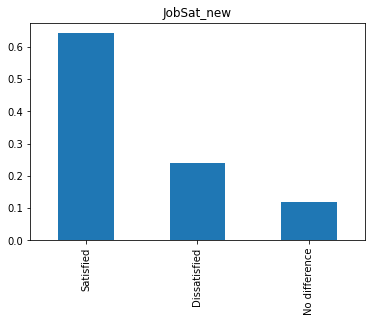

In [14]:
new_df, plt_val = get_plot_counts(developers_adj[developers_adj['Country'].isin(more30count_ls)], 'JobSat_new')
new_df

In [15]:
# top respondents having countries
data = developers_adj[developers_adj['Country'].isin(more30count_ls)]
pd.set_option('display.max_rows', 70)
# data = data[data['JobSat']=='Very satisfied']
data_crosstab = (pd.crosstab(data['Country'],
                            data['JobSat_new'], 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1))
                 
data_crosstab = data_crosstab.reset_index()
data_crosstab = data_crosstab.merge(new_df_count, on = 'Country').sort_values(by=['count_respondents_country'], 
                              ascending=False)
data_crosstab.head(5)

,Country,Dissatisfied,No difference,Satisfied,count_respondents_country
67,United States,0.197893,0.083677,0.718430,6549
27,India,0.265814,0.202212,0.531974,2893
66,United Kingdom,0.220981,0.093735,0.685284,2059
23,Germany,0.240650,0.105691,0.653659,1845
10,Canada,0.206128,0.090065,0.703807,1077


In [16]:
# highest dissatisfaction rates
data = developers_adj[developers_adj['Country'].isin(more30count_ls)]
pd.set_option('display.max_rows', 70)
# data = data[data['JobSat']=='Very satisfied']
data_crosstab = (pd.crosstab(data['Country'],
                            data['JobSat_new'], 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'], 
                              ascending=False))
data_crosstab = data_crosstab.reset_index()
data_crosstab = data_crosstab.merge(new_df_count, on = 'Country')
data_crosstab.head(5)

,Country,Dissatisfied,No difference,Satisfied,count_respondents_country
0,China,0.487500,0.237500,0.275000,80
1,Dominican Republic,0.447368,0.157895,0.394737,38
2,Egypt,0.381579,0.184211,0.434211,76
3,United Arab Emirates,0.347826,0.217391,0.434783,46
4,Chile,0.342105,0.144737,0.513158,76


In [17]:
# highest satisfaction rates
data = developers_adj[developers_adj['Country'].isin(more30count_ls)]
pd.set_option('display.max_rows', 70)
# data = data[data['JobSat']=='Very satisfied']
data_crosstab = (pd.crosstab(data['Country'],
                            data['JobSat_new'], 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Satisfied'], 
                              ascending=False))
data_crosstab = data_crosstab.reset_index()
data_crosstab = data_crosstab.merge(new_df_count, on = 'Country')
data_crosstab.head(5)

,Country,Dissatisfied,No difference,Satisfied,count_respondents_country
0,Lithuania,0.122449,0.122449,0.755102,98
1,Latvia,0.192308,0.057692,0.750000,52
2,Denmark,0.200000,0.050000,0.750000,180
3,Norway,0.184211,0.074561,0.741228,228
4,Sweden,0.164080,0.104213,0.731707,451


# Age wise analysis

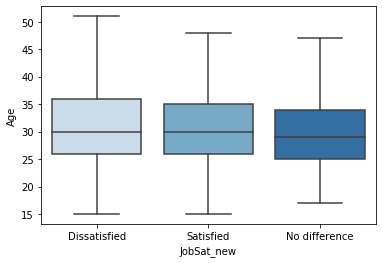

In [18]:
data = developers_adj
sns.boxplot(x = data['JobSat_new'],
           y = data['Age'],
           palette = 'Blues',
           showfliers = False)

quantile_age
(14.999, 26.0]    8398
(26.0, 30.0]      7259
(30.0, 35.0]      5836
(35.0, 60.0]      6935
Name: Respondent, dtype: int64

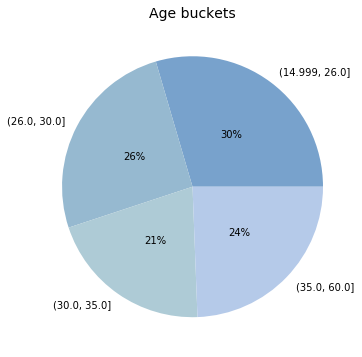

In [19]:
data=developers_adj[["quantile_age", "Respondent"]]
data = data.groupby("quantile_age")['Respondent'].count()
colors = ['#78A2CC','#96B9D0' , '#AECBD6', "#b5cae9"]
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  labels=labels, pctdistance=0.5, colors = colors)
plt.title("Age buckets", fontsize=14);
data

In [20]:
# dissatisfaction
data = developers_adj
data_crosstab = (pd.crosstab(data['quantile_age'],
                            data['JobSat_new'], 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'], ascending=False))
data_crosstab = data_crosstab.reset_index()
data_crosstab

JobSat_new,quantile_age,Dissatisfied,No difference,Satisfied
0,"(35.0, 60.0]",0.249171,0.102812,0.648017
1,"(26.0, 30.0]",0.246177,0.129908,0.623915
2,"(30.0, 35.0]",0.241947,0.107265,0.650788
3,"(14.999, 26.0]",0.228864,0.129793,0.641343


# Gender

,index,Gender
0,Man,25722
1,Woman,2083
2,"Non-binary, genderqueer, or gender non-conforming",179
3,"Man;Non-binary, genderqueer, or gender non-conforming",60
4,"Woman;Non-binary, genderqueer, or gender non-conforming",43
5,Woman;Man,19
6,"Woman;Man;Non-binary, genderqueer, or gender non-conforming",7


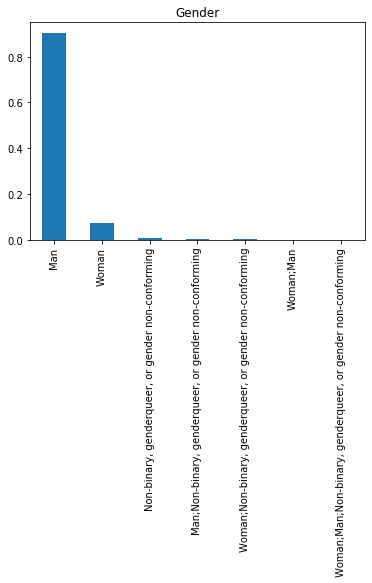

In [21]:
new_df, plt_val = get_plot_counts(developers_adj, 'Gender')
new_df

In [22]:
# since 99% are in these 2 groups we only analyse Man and Woman
data = (developers_adj
        [
            (developers_adj["Gender"]=='Man') | 
            (developers_adj["Gender"]=='Woman')
        ]
       )
# pd.set_option('display.max_rows', 70)
# data = data[data['JobSat']=='Very satisfied']
data_crosstab = pd.crosstab([data.Gender],
                            data.JobSat_new, 
                               margins = False).apply(lambda r: r/r.sum(), axis=1).sort_values(by=['Dissatisfied'], ascending=False)
data_crosstab = data_crosstab.reset_index()
data_crosstab

JobSat_new,Gender,Dissatisfied,No difference,Satisfied
0,Man,0.242400,0.119625,0.637975
1,Woman,0.231397,0.106097,0.662506


In [23]:
data = (developers_adj
        [
            (developers_adj["Gender"]=='Man') | 
            (developers_adj["Gender"]=='Woman')
        ]
       )
# pd.set_option('display.max_rows', 70)
# data = data[data['JobSat']=='Very satisfied']
data_crosstab = pd.crosstab([data.Gender, data.quantile_age],
                            data.JobSat_new, 
                               margins = False).apply(lambda r: r/r.sum(), axis=1).sort_values(by=['Dissatisfied'], ascending=False)
data_crosstab = data_crosstab.reset_index()
data_crosstab

JobSat_new,Gender,quantile_age,Dissatisfied,No difference,Satisfied
0,Man,"(35.0, 60.0]",0.250391,0.103561,0.646048
1,Man,"(26.0, 30.0]",0.248699,0.132537,0.618763
2,Woman,"(35.0, 60.0]",0.247423,0.077320,0.675258
3,Man,"(30.0, 35.0]",0.245198,0.107721,0.647081
4,Woman,"(14.999, 26.0]",0.237099,0.133891,0.629010
5,Man,"(14.999, 26.0]",0.228063,0.130551,0.641386
6,Woman,"(26.0, 30.0]",0.225919,0.098074,0.676007
7,Woman,"(30.0, 35.0]",0.213759,0.095823,0.690418


# Education

,index,EdLevel
0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",14515
1,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",7138
2,Some college/university study without earning a degree,3043
3,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",1085
4,"Associate degree (A.A., A.S., etc.)",931
5,"Other doctoral degree (Ph.D., Ed.D., etc.)",689
6,"Professional degree (JD, MD, etc.)",377
7,Primary/elementary school,103
8,I never completed any formal education,100


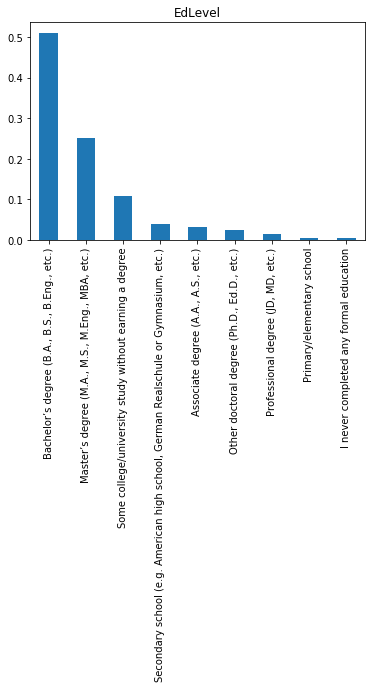

In [24]:
new_df_edu, plt_val = get_plot_counts(developers_adj, 'EdLevel')
new_df_edu

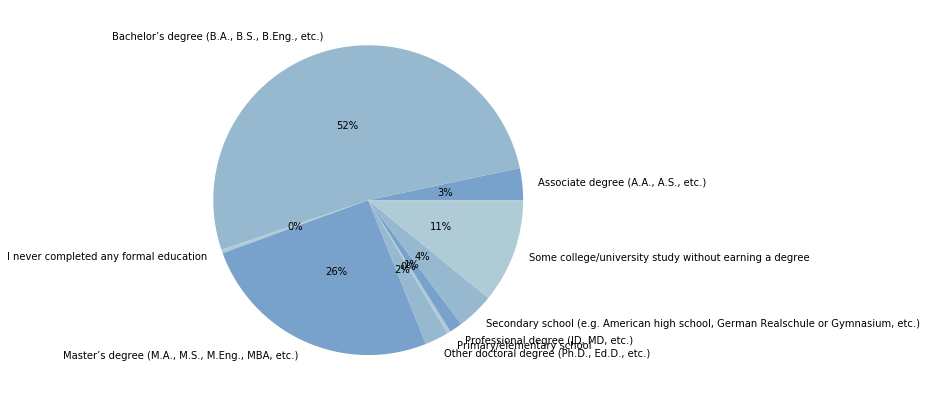

In [25]:
data=developers_adj[["EdLevel", "Respondent"]]
data = data.groupby("EdLevel")['Respondent'].count()
colors = ['#78A2CC','#96B9D0' , '#AECBD6']
explode = [0, 0.02, 0, 0.02, 0, 0, 0, 0, 0]
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  labels=labels, pctdistance=0.5, colors = colors, 
#         explode = explode
       )
# plt.title("Satisfaction percentage grouped", fontsize=14);
data
plt.tight_layout()

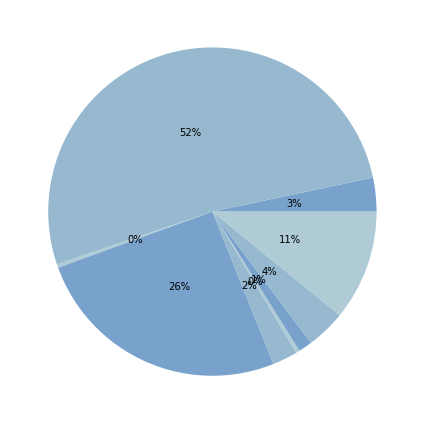

In [26]:
data=developers_adj[["EdLevel", "Respondent"]]
data = data.groupby("EdLevel")['Respondent'].count()
colors = ['#78A2CC','#96B9D0' , '#AECBD6']
pie, ax = plt.subplots(figsize=[10,6])
# labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  
        #labels=labels, 
        pctdistance=0.5, colors = colors)
# plt.title("Satisfaction percentage grouped", fontsize=14);
data
plt.tight_layout()

In [27]:
data = (developers_adj
#         [
#             (developers_adj["Country"]=='India') 
# #             |(developers_adj["Gender"]=='Woman')
#         ]
       )

data_crosstab = (pd.crosstab([data.EdLevel
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Satisfied'],
                              ascending=False
                              )
                )
new_df_edu.columns = ['EdLevel', 'count_respondents_ed_level']
data_crosstab = data_crosstab.merge(new_df_edu, on = 'EdLevel')

data_crosstab

,EdLevel,Dissatisfied,No difference,Satisfied,count_respondents_ed_level
0,"Other doctoral degree (Ph.D., Ed.D., etc.)",0.184325,0.081277,0.734398,689
1,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.247005,0.096774,0.656221,1085
2,Some college/university study without earning a degree,0.240223,0.105817,0.653960,3043
3,"Associate degree (A.A., A.S., etc.)",0.237379,0.114930,0.647691,931
4,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.235780,0.118661,0.645559,7138
5,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.244023,0.123390,0.632587,14515
6,"Professional degree (JD, MD, etc.)",0.328912,0.114058,0.557029,377
7,Primary/elementary school,0.281553,0.184466,0.533981,103
8,I never completed any formal education,0.340000,0.160000,0.500000,100


In [28]:
data = (developers_adj
#         [
#             (developers_adj["Country"]=='India') 
# #             |(developers_adj["Gender"]=='Woman')
#         ]
       )

data_crosstab = (pd.crosstab([data.EdLevel
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
new_df_edu.columns = ['EdLevel', 'count_respondents_ed_level']
data_crosstab = data_crosstab.merge(new_df_edu, on = 'EdLevel')

data_crosstab

,EdLevel,Dissatisfied,No difference,Satisfied,count_respondents_ed_level
0,I never completed any formal education,0.340000,0.160000,0.500000,100
1,"Professional degree (JD, MD, etc.)",0.328912,0.114058,0.557029,377
2,Primary/elementary school,0.281553,0.184466,0.533981,103
3,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.247005,0.096774,0.656221,1085
4,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.244023,0.123390,0.632587,14515
5,Some college/university study without earning a degree,0.240223,0.105817,0.653960,3043
6,"Associate degree (A.A., A.S., etc.)",0.237379,0.114930,0.647691,931
7,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.235780,0.118661,0.645559,7138
8,"Other doctoral degree (Ph.D., Ed.D., etc.)",0.184325,0.081277,0.734398,689


In [29]:
data = (developers_adj
        [
            (developers_adj["Country"]=='United Kingdom') 
#             |(developers_adj["Gender"]=='Woman')
        ]
       )
data_crosstab = (pd.crosstab([data.EdLevel
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Satisfied'],
                              ascending=False
                              )
                )
new_df_edu.columns = ['EdLevel', 'count_respondents_ed_level']
data_crosstab = data_crosstab.merge(new_df_edu, on = 'EdLevel')

data_crosstab

,EdLevel,Dissatisfied,No difference,Satisfied,count_respondents_ed_level
0,"Other doctoral degree (Ph.D., Ed.D., etc.)",0.152941,0.070588,0.776471,689
1,"Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",0.181818,0.070707,0.747475,1085
2,"Professional degree (JD, MD, etc.)",0.142857,0.142857,0.714286,377
3,Some college/university study without earning a degree,0.203704,0.107407,0.688889,3043
4,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",0.225962,0.088462,0.685577,14515
5,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",0.227459,0.104508,0.668033,7138
6,"Associate degree (A.A., A.S., etc.)",0.270270,0.108108,0.621622,931
7,Primary/elementary school,0.000000,0.500000,0.500000,103
8,I never completed any formal education,0.600000,0.000000,0.400000,100


# UndergradMajor

In [30]:
data = (developers_adj
#         [
#             (developers_adj["Country"]=='United Kingdom') 
# #             |(developers_adj["Gender"]=='Woman')
#         ]
       )
data_crosstab = (pd.crosstab([data.UndergradMajor
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Satisfied'],
                              ascending=False
                              )
                )
# new_df_edu.columns = ['EdLevel', 'count_respondents_ed_level']
# data_crosstab = data_crosstab.merge(new_df_edu, on = 'EdLevel')

data_crosstab

JobSat_new,Dissatisfied,No difference,Satisfied
UndergradMajor,,,
"A social science (such as anthropology, psychology, political science, etc.)",0.215686,0.071078,0.713235
"A natural science (such as biology, chemistry, physics, etc.)",0.202985,0.089552,0.707463
"Fine arts or performing arts (such as graphic design, music, studio art, etc.)",0.179144,0.114973,0.705882
"A health science (such as nursing, pharmacy, radiology, etc.)",0.173333,0.133333,0.693333
"A humanities discipline (such as literature, history, philosophy, etc.)",0.237037,0.079630,0.683333
"A business discipline (such as accounting, finance, marketing, etc.)",0.217699,0.115044,0.667257
Mathematics or statistics,0.229872,0.106184,0.663944
I never declared a major,0.253968,0.100529,0.645503
"Another engineering discipline (such as civil, electrical, mechanical, etc.)",0.246312,0.109522,0.644166


In [31]:
data = (developers_adj
#         [
#             (developers_adj["Country"]=='United Kingdom') 
# #             |(developers_adj["Gender"]=='Woman')
#         ]
       )
data_crosstab = (pd.crosstab([data.UndergradMajor
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
# new_df_edu.columns = ['EdLevel', 'count_respondents_ed_level']
# data_crosstab = data_crosstab.merge(new_df_edu, on = 'EdLevel')

data_crosstab

JobSat_new,Dissatisfied,No difference,Satisfied
UndergradMajor,,,
I never declared a major,0.253968,0.100529,0.645503
"Information systems, information technology, or system administration",0.249755,0.139352,0.610893
"Another engineering discipline (such as civil, electrical, mechanical, etc.)",0.246312,0.109522,0.644166
"Computer science, computer engineering, or software engineering",0.243601,0.122372,0.634027
Web development or web design,0.240506,0.140506,0.618987
"A humanities discipline (such as literature, history, philosophy, etc.)",0.237037,0.079630,0.683333
Mathematics or statistics,0.229872,0.106184,0.663944
"A business discipline (such as accounting, finance, marketing, etc.)",0.217699,0.115044,0.667257
"A social science (such as anthropology, psychology, political science, etc.)",0.215686,0.071078,0.713235


# Salary

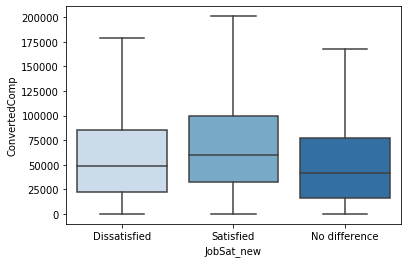

In [32]:
data = developers_adj[developers_adj['ConvertedComp']>0]
sns.boxplot(x = data['JobSat_new'],
           y = data['ConvertedComp'],
           palette = 'Blues',
           showfliers = False)

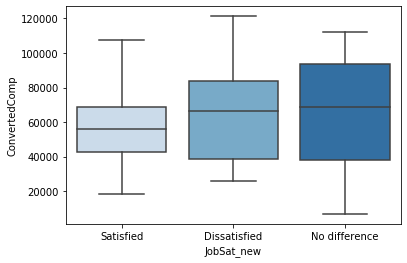

In [33]:
data = (developers_adj
        [
            (developers_adj["Country"]=='Singapore') 
#             |(developers_adj["Gender"]=='Man')
        ]
       )
sns.boxplot(x = data['JobSat_new'],
           y = data['ConvertedComp'],
           palette = 'Blues',
           showfliers = False)

# Hobbyist

In [35]:
data=developers_adj
# data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')]
data_crosstab = (pd.crosstab([data.Hobbyist,
#                               data.Gender,
#                               data.work_hr_bucket#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab

JobSat_new,Dissatisfied,No difference,Satisfied
Hobbyist,,,
No,0.243153,0.129218,0.627629
Yes,0.240249,0.115404,0.644347


# Work week hours

In [36]:
# work week hours remove outliers and group
print("Highest allowed",developers_adj['WorkWeekHrs'].mean() + 3*developers_adj['WorkWeekHrs'].std())
print("Lowest allowed",developers_adj['WorkWeekHrs'].mean() - 3*developers_adj['WorkWeekHrs'].std())

data = developers_adj
df = data[(data["WorkWeekHrs"]<8) | (data["WorkWeekHrs"]>94)]
data.shape, data.isna().sum()['WorkWeekHrs'],df.shape

work_data = developers_adj[(developers_adj["WorkWeekHrs"]>= 8)]
work_data = work_data[work_data["WorkWeekHrs"]<=94]          

work_data['work_hr_bucket'] = pd.cut(work_data['WorkWeekHrs'], bins=4)

Highest allowed 92.52128418739113
Lowest allowed -10.410490467601853


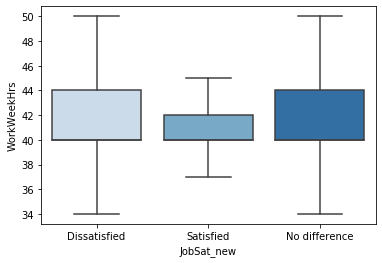

In [37]:
data = developers_adj[developers_adj['WorkWeekHrs']>0]
sns.boxplot(x = data['JobSat_new'],
           y = data['WorkWeekHrs'],
           palette = 'Blues',
           showfliers = False)

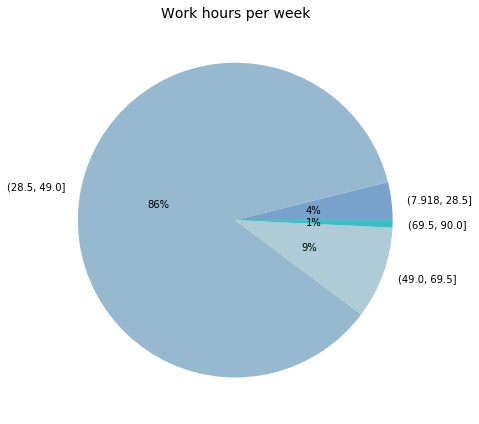

In [38]:
# oie chart - distribution
data=work_data[["work_hr_bucket", "Respondent"]]
data = data.groupby("work_hr_bucket")['Respondent'].count()
colors = ['#78A2CC','#96B9D0' , '#AECBD6', '#3bbdc2']
pie, ax = plt.subplots(figsize=[10,6])
labels = data.keys()
plt.pie(x=data, autopct="%.0f%%",  
        labels=labels, 
        pctdistance=0.5, colors = colors)
plt.title("Work hours per week", fontsize=14);
data
plt.tight_layout()

,work_hr_bucket,count_respondents_work_hr_bucket
0,"(28.5, 49.0]",23476
1,"(49.0, 69.5]",2587
2,"(7.918, 28.5]",1064
3,"(69.5, 90.0]",210


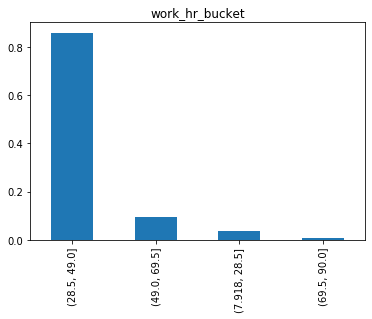

In [39]:
# bar chart- distibution
new_df_count, plt_val = get_plot_counts(work_data, 'work_hr_bucket')
pd.set_option('display.max_rows', 10)
new_df_count.columns = ['work_hr_bucket', 'count_respondents_work_hr_bucket']
new_df_count

In [40]:
# disssatifaction with percentages and counts
data=work_data
data_crosstab = (pd.crosstab([data.work_hr_bucket#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['work_hr_bucket'],
                              ascending=True
                              )
                )
data_crosstab = data_crosstab.reset_index()
data_crosstab = (data_crosstab
                 .merge(new_df_count, on = 'work_hr_bucket')
                )
data_crosstab

,work_hr_bucket,Dissatisfied,No difference,Satisfied,count_respondents_work_hr_bucket
0,"(7.918, 28.5]",0.291353,0.167293,0.541353,1064
1,"(28.5, 49.0]",0.235858,0.113137,0.651005,23476
2,"(49.0, 69.5]",0.260147,0.130267,0.609586,2587
3,"(69.5, 90.0]",0.290476,0.123810,0.585714,210


In [41]:
# gender wise satsifaction rates
data=work_data
data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')]
data_crosstab = (pd.crosstab([data.Gender,
                              data.work_hr_bucket#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab

JobSat_new             Dissatisfied  No difference  Satisfied
Gender work_hr_bucket                                        
Woman  (49.0, 69.5]        0.317829       0.116279   0.565891
Man    (69.5, 90.0]        0.300000       0.115789   0.584211
       (7.918, 28.5]       0.294898       0.165306   0.539796
       (49.0, 69.5]        0.257903       0.130616   0.611481
       (28.5, 49.0]        0.237390       0.114425   0.648186
Woman  (7.918, 28.5]       0.228571       0.228571   0.542857
       (28.5, 49.0]        0.225479       0.096956   0.677565
       (69.5, 90.0]        0.181818       0.272727   0.545455

In [42]:
# gender wise satsifaction rates
data=work_data
data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')]
data_crosstab = (pd.crosstab([data.Gender,
                              data.work_hr_bucket#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab

JobSat_new             Dissatisfied  No difference  Satisfied
Gender work_hr_bucket                                        
Woman  (49.0, 69.5]        0.317829       0.116279   0.565891
Man    (69.5, 90.0]        0.300000       0.115789   0.584211
       (7.918, 28.5]       0.294898       0.165306   0.539796
       (49.0, 69.5]        0.257903       0.130616   0.611481
       (28.5, 49.0]        0.237390       0.114425   0.648186
Woman  (7.918, 28.5]       0.228571       0.228571   0.542857
       (28.5, 49.0]        0.225479       0.096956   0.677565
       (69.5, 90.0]        0.181818       0.272727   0.545455

In [43]:
pd.set_option('display.max_rows', 20)
data=work_data
data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')]
data_crosstab = (pd.crosstab([data.Hobbyist,
                              data.Gender,
                              data.work_hr_bucket#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab

JobSat_new                      Dissatisfied  No difference  Satisfied
Hobbyist Gender work_hr_bucket                                        
No       Man    (69.5, 90.0]        0.360000       0.240000   0.400000
Yes      Woman  (49.0, 69.5]        0.342105       0.078947   0.578947
                (69.5, 90.0]        0.333333       0.333333   0.333333
         Man    (7.918, 28.5]       0.297680       0.159794   0.542526
                (69.5, 90.0]        0.290909       0.096970   0.612121
No       Man    (49.0, 69.5]        0.287946       0.160714   0.551339
                (7.918, 28.5]       0.284314       0.186275   0.529412
         Woman  (49.0, 69.5]        0.283019       0.169811   0.547170
Yes      Man    (49.0, 69.5]        0.251022       0.123722   0.625256
         Woman  (7.918, 28.5]       0.243902       0.146341   0.609756
No       Man    (28.5, 49.0]        0.240103       0.124331   0.635566
Yes      Man    (28.5, 49.0]        0.236622       0.111622   0.651755
         Woman  (28.5, 49.0]        0.226396       0.101523   0.672081
No       Woman  (28.5, 49.0]        0.224335       0.091255   0.684411
                (7.918, 28.5]       0.206897       0.344828   0.448276
                (69.5, 90.0]        0.000000       0.200000   0.800000

# Overtime work

,NEWOvertime,count_respondents_overtime
0,Sometimes: 1-2 days per month but less than weekly,7658
1,Often: 1-2 days per week or more,6518
2,Occasionally: 1-2 days per quarter but less than monthly,6465
3,Rarely: 1-2 days per year or less,4549
4,Never,3065


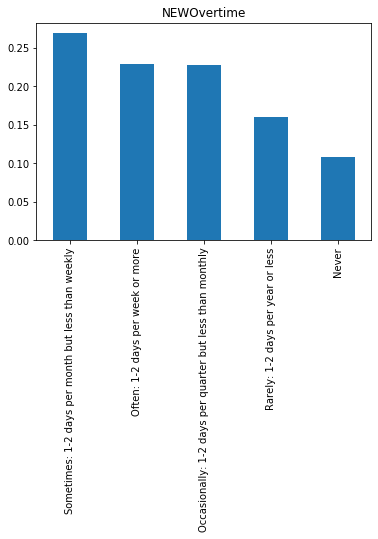

In [44]:
# bar chart- distibution
new_df_count, plt_val = get_plot_counts(developers_adj, 'NEWOvertime')
pd.set_option('display.max_rows', 10)
new_df_count.columns = ['NEWOvertime', 'count_respondents_overtime']
new_df_count

In [45]:
# disssatifaction with percentages and counts
data=developers_adj
data_crosstab = (pd.crosstab([data.NEWOvertime#, data.quantile_age
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab = data_crosstab.reset_index()
data_crosstab = (data_crosstab
                 .merge(new_df_count, on = 'NEWOvertime')
                )
data_crosstab

,NEWOvertime,Dissatisfied,No difference,Satisfied,count_respondents_overtime
0,Never,0.272757,0.124307,0.602936,3065
1,Often: 1-2 days per week or more,0.263424,0.119362,0.617214,6518
2,Rarely: 1-2 days per year or less,0.242691,0.124203,0.633106,4549
3,Sometimes: 1-2 days per month but less than weekly,0.224210,0.112301,0.663489,7658
4,Occasionally: 1-2 days per quarter but less than monthly,0.222274,0.117865,0.659861,6465


In [46]:

# disssatifaction with percentages and counts
data=developers_adj
data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')
           ]
data_crosstab = (pd.crosstab([data.Gender, data.Hobbyist, data.NEWOvertime
                            ],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab = data_crosstab.reset_index()
data_crosstab = (data_crosstab
#                  .merge(new_df_count, on = 'NEWOvertime')
                )
data_crosstab

JobSat_new,Gender,Hobbyist,NEWOvertime,Dissatisfied,No difference,Satisfied
0,Woman,Yes,Often: 1-2 days per week or more,0.333333,0.089744,0.576923
1,Woman,No,Often: 1-2 days per week or more,0.315152,0.103030,0.581818
2,Woman,Yes,Never,0.302158,0.115108,0.582734
3,Man,No,Never,0.274571,0.146646,0.578783
4,Man,Yes,Never,0.270386,0.117787,0.611826
...,...,...,...,...,...,...
15,Woman,Yes,Sometimes: 1-2 days per month but less than weekly,0.216718,0.077399,0.705882
16,Woman,No,Occasionally: 1-2 days per quarter but less than monthly,0.207792,0.103896,0.688312
17,Woman,Yes,Rarely: 1-2 days per year or less,0.202899,0.149758,0.647343
18,Woman,No,Rarely: 1-2 days per year or less,0.172840,0.092593,0.734568


# Job factors

dict_items([('Remote work options', 9141), ('Opportunities for professional development', 11402), ('Family friendliness', 3244), ('Flex time or a flexible schedule', 12575), ('How widely used or impactful my work output would be', 5638), ('Languages, frameworks, and other technologies I’d be working with', 15223), ('Office environment or company culture', 13149), ('Industry that I’d be working in', 3886), ('Specific department or team I’d be working on', 3140), ('Financial performance or funding status of the company or organization', 3252), ('Diversity of the company or organization', 1785)])


,str_seleted,counts,frac
0,Remote work options,9141,0.110887
1,Opportunities for professional development,11402,0.138315
2,Family friendliness,3244,0.039352
3,Flex time or a flexible schedule,12575,0.152544
4,How widely used or impactful my work output would be,5638,0.068393
...,...,...,...
6,Office environment or company culture,13149,0.159507
7,Industry that I’d be working in,3886,0.047140
8,Specific department or team I’d be working on,3140,0.038091
9,Financial performance or funding status of the company or organization,3252,0.039449


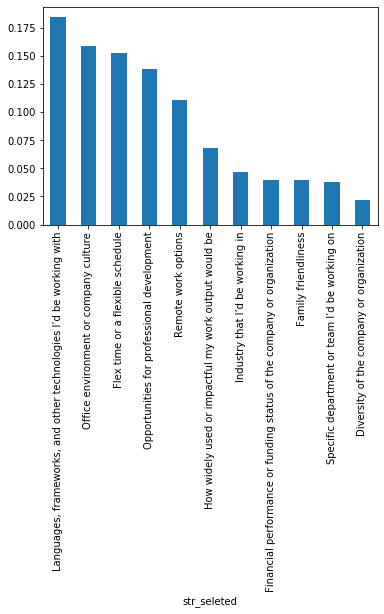

In [47]:
cleaned_job_fac=clean_series_in_columns(developers_adj, 'JobFactors')
cleaned_job_fac

dict_items([('Remote work options', 2375), ('Opportunities for professional development', 2895), ('Family friendliness', 751), ('Flex time or a flexible schedule', 2929), ('Languages, frameworks, and other technologies I’d be working with', 3743), ('Office environment or company culture', 3030), ('Industry that I’d be working in', 871), ('Financial performance or funding status of the company or organization', 822), ('Specific department or team I’d be working on', 717), ('Diversity of the company or organization', 435), ('How widely used or impactful my work output would be', 1373)])


,str_seleted,counts,frac
0,Remote work options,2375,0.119101
1,Opportunities for professional development,2895,0.145178
2,Family friendliness,751,0.037661
3,Flex time or a flexible schedule,2929,0.146883
4,"Languages, frameworks, and other technologies I’d be working with",3743,0.187704
...,...,...,...
6,Industry that I’d be working in,871,0.043679
7,Financial performance or funding status of the company or organization,822,0.041222
8,Specific department or team I’d be working on,717,0.035956
9,Diversity of the company or organization,435,0.021814


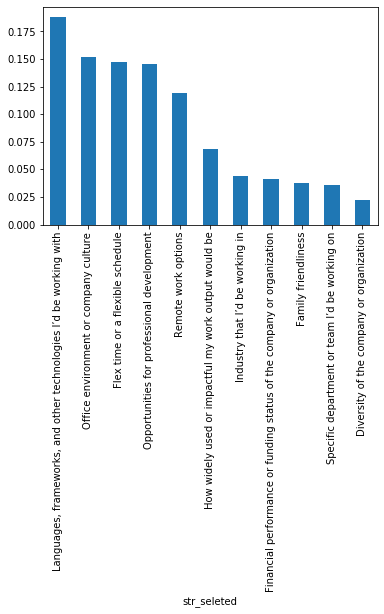

In [48]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
cleaned_job_fac=clean_series_in_columns(data, 'JobFactors')
cleaned_job_fac

dict_items([('Diversity of the company or organization', 109), ('Languages, frameworks, and other technologies I’d be working with', 217), ('Opportunities for professional development', 203), ('Flex time or a flexible schedule', 217), ('How widely used or impactful my work output would be', 84), ('Remote work options', 173), ('Family friendliness', 38), ('Specific department or team I’d be working on', 59), ('Office environment or company culture', 216), ('Financial performance or funding status of the company or organization', 38), ('Industry that I’d be working in', 52)])


,str_seleted,counts,frac
0,Diversity of the company or organization,109,0.077525
1,"Languages, frameworks, and other technologies I’d be working with",217,0.154339
2,Opportunities for professional development,203,0.144381
3,Flex time or a flexible schedule,217,0.154339
4,How widely used or impactful my work output would be,84,0.059744
...,...,...,...
6,Family friendliness,38,0.027027
7,Specific department or team I’d be working on,59,0.041963
8,Office environment or company culture,216,0.153627
9,Financial performance or funding status of the company or organization,38,0.027027


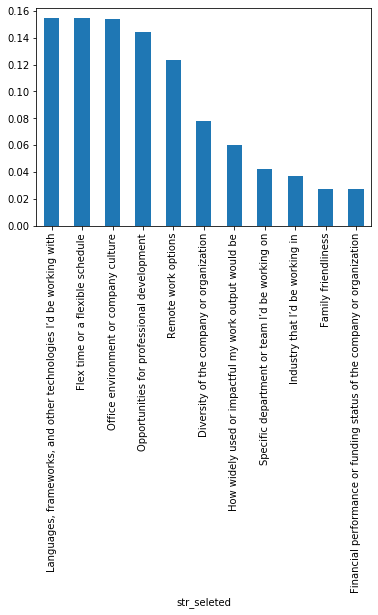

In [49]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
data = data[data['Gender']=='Woman']
cleaned_job_fac=clean_series_in_columns(data, 'JobFactors')
cleaned_job_fac



dict_items([('Remote work options', 2154), ('Opportunities for professional development', 2648), ('Family friendliness', 705), ('Flex time or a flexible schedule', 2668), ('Languages, frameworks, and other technologies I’d be working with', 3466), ('Office environment or company culture', 2759), ('Industry that I’d be working in', 784), ('Financial performance or funding status of the company or organization', 768), ('Specific department or team I’d be working on', 642), ('How widely used or impactful my work output would be', 1264), ('Diversity of the company or organization', 290)])


,str_seleted,counts,frac
4,"Languages, frameworks, and other technologies I’d be working with",3466,0.190985
5,Office environment or company culture,2759,0.152028
3,Flex time or a flexible schedule,2668,0.147013
1,Opportunities for professional development,2648,0.145911
0,Remote work options,2154,0.118691
...,...,...,...
6,Industry that I’d be working in,784,0.043200
7,Financial performance or funding status of the company or organization,768,0.042319
2,Family friendliness,705,0.038847
8,Specific department or team I’d be working on,642,0.035376


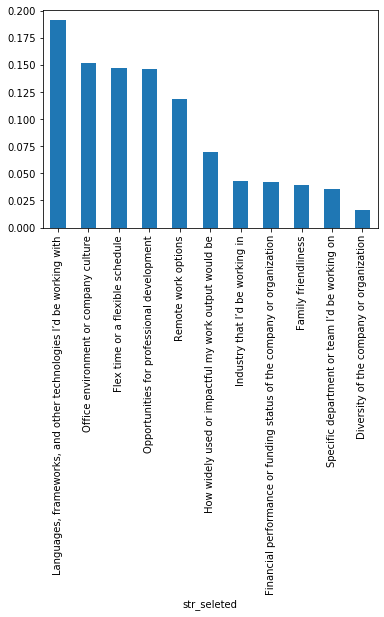

In [50]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
data = data[data['Gender']=='Man']
cleaned_job_fac=clean_series_in_columns(data, 'JobFactors')
cleaned_job_fac.sort_values('frac', ascending=False
                              )

dict_items([('Remote work options', 692), ('Opportunities for professional development', 656), ('Family friendliness', 306), ('Office environment or company culture', 701), ('Flex time or a flexible schedule', 718), ('Financial performance or funding status of the company or organization', 213), ('Industry that I’d be working in', 206), ('Languages, frameworks, and other technologies I’d be working with', 924), ('Diversity of the company or organization', 106), ('Specific department or team I’d be working on', 173), ('How widely used or impactful my work output would be', 346)])


,str_seleted,counts,frac
7,"Languages, frameworks, and other technologies I’d be working with",924,0.183297
4,Flex time or a flexible schedule,718,0.142432
3,Office environment or company culture,701,0.139060
0,Remote work options,692,0.137274
1,Opportunities for professional development,656,0.130133
...,...,...,...
2,Family friendliness,306,0.060702
5,Financial performance or funding status of the company or organization,213,0.042254
6,Industry that I’d be working in,206,0.040865
9,Specific department or team I’d be working on,173,0.034319


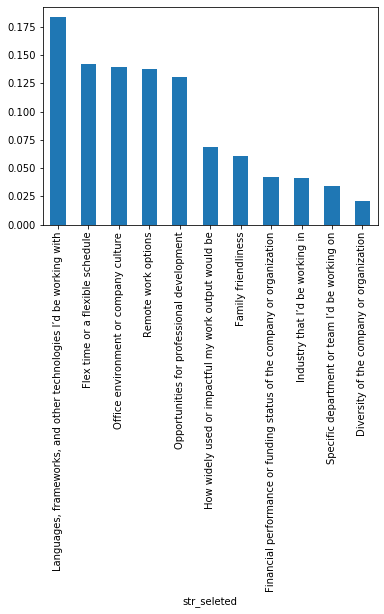

In [51]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'JobFactors')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )

# JobSeek

In [52]:
data = developers_adj
# data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')
#            ]
data_crosstab = (pd.crosstab([data.JobSeek],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab = data_crosstab.reset_index()
data_crosstab = (data_crosstab
#                  .merge(new_df_count, on = 'NEWOvertime')
                )
data_crosstab

JobSat_new,JobSeek,Dissatisfied,No difference,Satisfied
0,I am actively looking for a job,0.541667,0.172660,0.285674
1,"I’m not actively looking, but I am open to new opportunities",0.239222,0.145071,0.615708
2,I am not interested in new job opportunities,0.113038,0.039177,0.847785


dict_items([('Flex time or a flexible schedule', 1377), ('Languages, frameworks, and other technologies I’d be working with', 1921), ('Remote work options', 1158), ('Financial performance or funding status of the company or organization', 520), ('Industry that I’d be working in', 439), ('Opportunities for professional development', 1613), ('How widely used or impactful my work output would be', 662), ('Diversity of the company or organization', 247), ('Office environment or company culture', 1536), ('Specific department or team I’d be working on', 317), ('Family friendliness', 334)])


,str_seleted,counts,frac
1,"Languages, frameworks, and other technologies I’d be working with",1921,0.189747
5,Opportunities for professional development,1613,0.159324
8,Office environment or company culture,1536,0.151719
0,Flex time or a flexible schedule,1377,0.136013
2,Remote work options,1158,0.114382
...,...,...,...
3,Financial performance or funding status of the company or organization,520,0.051363
4,Industry that I’d be working in,439,0.043362
10,Family friendliness,334,0.032991
9,Specific department or team I’d be working on,317,0.031312


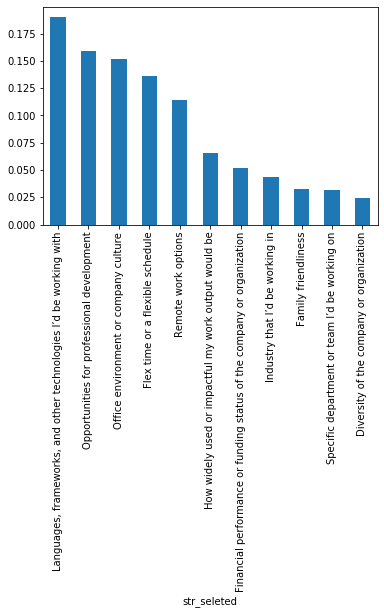

In [53]:
data = developers_adj[developers_adj['JobSeek']=='I am actively looking for a job']
# data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'JobFactors')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )

In [54]:
data = developers_adj
# data = data[(data["Gender"]=='Man') | (data["Gender"]=='Woman')
#            ]
data_crosstab = (pd.crosstab([data.JobSeek, data.quantile_age],
                            data.JobSat_new, 
                               margins = False)
                 .apply(lambda r: r/r.sum(), axis=1)
                 .sort_values(by=['Dissatisfied'],
                              ascending=False
                              )
                )
data_crosstab = data_crosstab.reset_index()
data_crosstab = (data_crosstab
#                  .merge(new_df_count, on = 'NEWOvertime')
                )
data_crosstab

JobSat_new,JobSeek,quantile_age,Dissatisfied,No difference,Satisfied
0,I am actively looking for a job,"(35.0, 60.0]",0.629085,0.114379,0.256536
1,I am actively looking for a job,"(30.0, 35.0]",0.565749,0.172783,0.261468
2,I am actively looking for a job,"(26.0, 30.0]",0.523232,0.186869,0.289899
3,I am actively looking for a job,"(14.999, 26.0]",0.500801,0.189904,0.309295
4,"I’m not actively looking, but I am open to new opportunities","(35.0, 60.0]",0.265291,0.135753,0.598956
...,...,...,...,...,...
7,"I’m not actively looking, but I am open to new opportunities","(14.999, 26.0]",0.215717,0.153403,0.630879
8,I am not interested in new job opportunities,"(30.0, 35.0]",0.127962,0.036137,0.835900
9,I am not interested in new job opportunities,"(35.0, 60.0]",0.119948,0.042156,0.837897
10,I am not interested in new job opportunities,"(26.0, 30.0]",0.106527,0.039687,0.853786


# NEWJobHunt

dict_items([('Curious about other opportunities', 16001), ('Better compensation', 20063), ('Trouble with my direct manager', 5042), ('Trouble with leadership at my company', 8097), ('Better work/life balance', 13231), ('Wanting to work with new technologies', 16360), ('Growth or leadership opportunities', 14854), ('Looking to relocate', 7504), ('Wanting to share accomplishments with a wider network', 2481), ('Having a bad day (or week or month) at work', 6275), ('Trouble with my teammates', 3530), ('Just because', 3169)])


,str_seleted,counts,frac
1,Better compensation,20063,0.172057
5,Wanting to work with new technologies,16360,0.140300
0,Curious about other opportunities,16001,0.137222
6,Growth or leadership opportunities,14854,0.127385
4,Better work/life balance,13231,0.113467
...,...,...,...
9,Having a bad day (or week or month) at work,6275,0.053813
2,Trouble with my direct manager,5042,0.043239
10,Trouble with my teammates,3530,0.030273
11,Just because,3169,0.027177


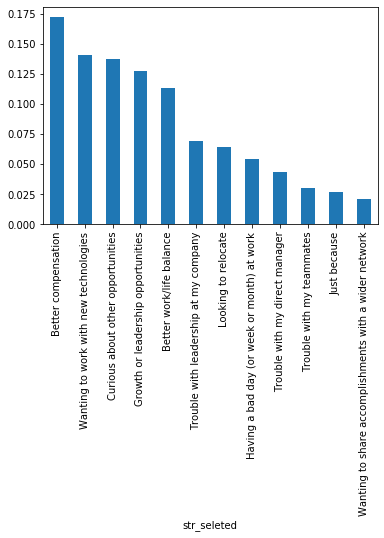

In [55]:
data = developers_adj#[developers_adj['JobSeek']=='I am actively looking for a job']
# data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'NEWJobHunt')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )

dict_items([('Curious about other opportunities', 1836), ('Better compensation', 2499), ('Trouble with leadership at my company', 1119), ('Better work/life balance', 1714), ('Wanting to work with new technologies', 2191), ('Growth or leadership opportunities', 2032), ('Wanting to share accomplishments with a wider network', 493), ('Looking to relocate', 1114), ('Having a bad day (or week or month) at work', 714), ('Trouble with my teammates', 298), ('Trouble with my direct manager', 537), ('Just because', 272)])


,str_seleted,counts,frac
1,Better compensation,2499,0.168635
4,Wanting to work with new technologies,2191,0.147851
5,Growth or leadership opportunities,2032,0.137121
0,Curious about other opportunities,1836,0.123895
3,Better work/life balance,1714,0.115662
...,...,...,...
8,Having a bad day (or week or month) at work,714,0.048181
10,Trouble with my direct manager,537,0.036237
6,Wanting to share accomplishments with a wider network,493,0.033268
9,Trouble with my teammates,298,0.020109


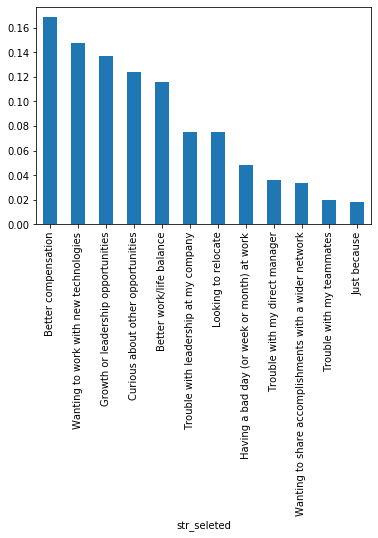

In [57]:
data = developers_adj[developers_adj['JobSeek']=='I am actively looking for a job']
# data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'NEWJobHunt')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )

dict_items([('Curious about other opportunities', 3734), ('Better compensation', 4923), ('Trouble with my direct manager', 1359), ('Trouble with leadership at my company', 2486), ('Better work/life balance', 3244), ('Wanting to work with new technologies', 4152), ('Growth or leadership opportunities', 3652), ('Having a bad day (or week or month) at work', 2045), ('Trouble with my teammates', 902), ('Just because', 624), ('Looking to relocate', 1698), ('Wanting to share accomplishments with a wider network', 734)])


,str_seleted,counts,frac
1,Better compensation,4923,0.166582
5,Wanting to work with new technologies,4152,0.140493
0,Curious about other opportunities,3734,0.126349
6,Growth or leadership opportunities,3652,0.123575
4,Better work/life balance,3244,0.109769
...,...,...,...
10,Looking to relocate,1698,0.057456
2,Trouble with my direct manager,1359,0.045985
8,Trouble with my teammates,902,0.030521
11,Wanting to share accomplishments with a wider network,734,0.024837


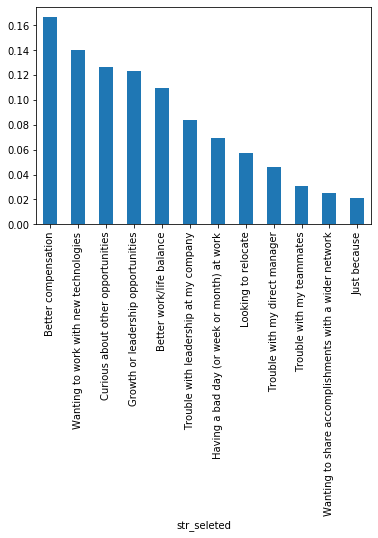

In [58]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
# data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'NEWJobHunt')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )

dict_items([('Trouble with leadership at my company', 3), ('Better work/life balance', 10), ('Wanting to work with new technologies', 11), ('Growth or leadership opportunities', 12), ('Curious about other opportunities', 10), ('Better compensation', 12), ('Trouble with my teammates', 3), ('Looking to relocate', 7), ('Having a bad day (or week or month) at work', 3), ('Wanting to share accomplishments with a wider network', 2), ('Trouble with my direct manager', 1)])


,str_seleted,counts,frac
3,Growth or leadership opportunities,12,0.162162
5,Better compensation,12,0.162162
2,Wanting to work with new technologies,11,0.148649
1,Better work/life balance,10,0.135135
4,Curious about other opportunities,10,0.135135
...,...,...,...
0,Trouble with leadership at my company,3,0.040541
6,Trouble with my teammates,3,0.040541
8,Having a bad day (or week or month) at work,3,0.040541
9,Wanting to share accomplishments with a wider network,2,0.027027


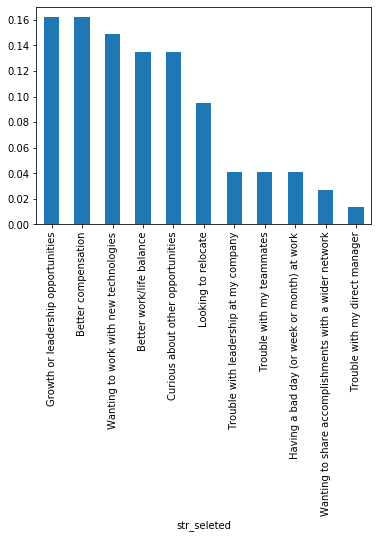

In [59]:
data = developers_adj[developers_adj['JobSat_new']=='Dissatisfied']
data = data[data['Country']=='United Arab Emirates']
# data = data[data['NEWOvertime']=='Often: 1-2 days per week or more']

# data = data[(data['Age'] > 35.00) & (data['Age'] <= 65.0) ]
            
#             '(14.999, 26.0]']
cleaned_job_fac=clean_series_in_columns(data, 'NEWJobHunt')
cleaned_job_fac.sort_values('frac', 
                            ascending=False
                            )